# Retail AI Mini Project
## Customer Segmentation | Sales Forecasting | Revenue Strategy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

print("All libraries loaded successfully!")

All libraries loaded successfully!


In [3]:
df = pd.read_csv('retail_data.csv')  # ← replace with actual filename you uploaded
print("Shape:", df.shape)
df.head()

Shape: (302010, 30)


,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,...,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,...,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,...,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment
3,7232460.0,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,...,2466.854021,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.0,Utility knife
4,4983775.0,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,...,248.553049,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.0,Chocolate cookies


In [4]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Check column names so you can adjust below
print("\nColumn names:", df.columns.tolist())

Missing values:
 Transaction_ID      333
Customer_ID         308
Name                382
Email               347
Phone               362
Address             315
City                248
State               281
Zipcode             340
Country             271
Age                 173
Gender              317
Income              290
Customer_Segment    215
Date                359
Year                350
Month               273
Time                350
Total_Purchases     361
Amount              357
Total_Amount        350
Product_Category    283
Product_Brand       281
Product_Type          0
Feedback            184
Shipping_Method     337
Payment_Method      297
Order_Status        235
Ratings             184
products              0
dtype: int64

Column names: ['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address', 'City', 'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income', 'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases', 'Amount', 'Total_Amount', 

In [8]:
# Convert date column to datetime, using 'mixed' format and assuming day comes first
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

# NOTE: Based on the `df.columns.tolist()` output from a previous cell,
# 'Quantity' and 'Price' columns do not exist in your DataFrame.
# If 'Total_Amount' already represents the revenue, you might use it directly.
# If you meant to use 'Amount' and 'Total_Purchases' (assuming Total_Purchases is quantity),
# you would need to adjust the line below accordingly.
# For now, this line will cause a KeyError.
# Placeholder for Revenue calculation - PLEASE REVIEW AND ADJUST
df['Revenue'] = df['Total_Amount'] # Assuming Total_Amount is already the revenue, or needs to be calculated differently

# Extract time features
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek

print("New columns added. Sample:")
df[['Date', 'Total_Amount', 'Revenue', 'Month', 'Year']].head()

New columns added. Sample:


,Date,Total_Amount,Revenue,Month,Year
0,2023-09-18,324.086270,324.086270,9,2023
1,2023-12-31,806.707815,806.707815,12,2023
2,2023-04-26,1063.432799,1063.432799,4,2023
3,2023-08-05,2466.854021,2466.854021,8,2023
4,2024-10-01,248.553049,248.553049,10,2024


📊 Exploratory Data Analysis (EDA)

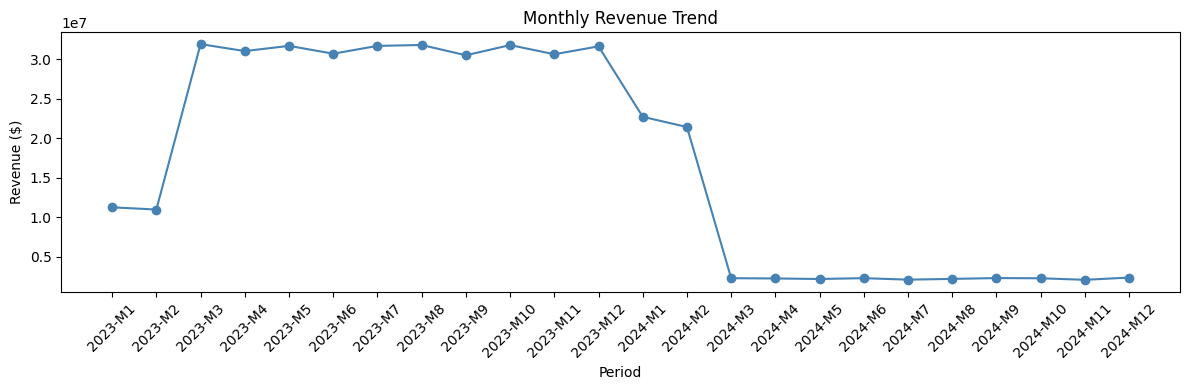

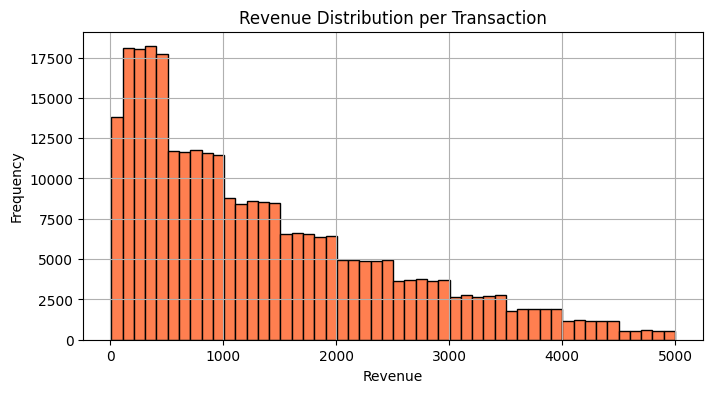

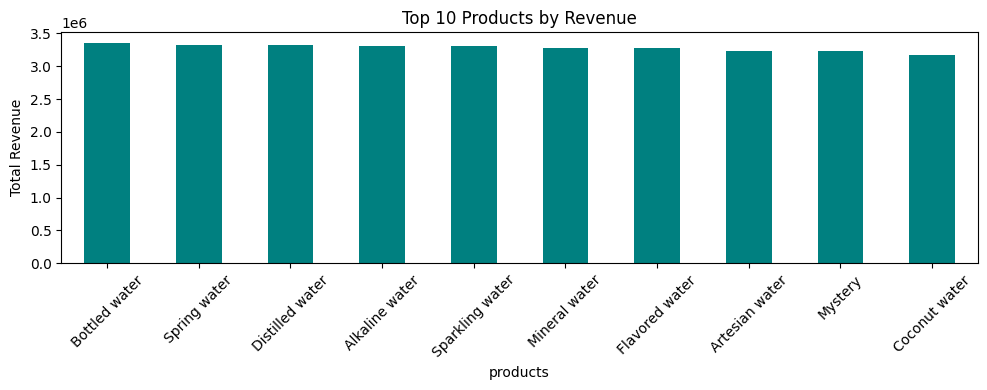

In [10]:
# Chart 1: Monthly Revenue Trend
monthly_revenue = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
monthly_revenue['Period'] = monthly_revenue['Year'].astype(str) + '-M' + monthly_revenue['Month'].astype(str)

plt.figure(figsize=(12, 4))
plt.plot(monthly_revenue['Period'], monthly_revenue['Revenue'], marker='o', color='steelblue')
plt.title('Monthly Revenue Trend')
plt.xlabel('Period')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chart 2: Revenue Distribution
plt.figure(figsize=(8, 4))
df['Revenue'].hist(bins=50, color='coral', edgecolor='black')
plt.title('Revenue Distribution per Transaction')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

# Chart 3: Top 10 Products by Revenue
top_products = df.groupby('products')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 4))
top_products.plot(kind='bar', color='teal')
plt.title('Top 10 Products by Revenue')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Customer Segmentation using K-Means Clustering

In [12]:
# Step 1: Aggregate data per customer
customer_df = df.groupby('Customer_ID').agg(
    TotalRevenue=('Revenue', 'sum'),
    TotalOrders=('Revenue', 'count'),
    AvgOrderValue=('Revenue', 'mean')
).reset_index()

print("Customer summary:")
customer_df.head()

Customer summary:


,Customer_ID,TotalRevenue,TotalOrders,AvgOrderValue
0,10000.0,5007.566357,4,1251.891589
1,10001.0,8136.462824,5,1627.292565
2,10002.0,4104.013951,5,820.802790
3,10003.0,2340.496447,2,1170.248223
4,10004.0,2356.516683,2,1178.258341


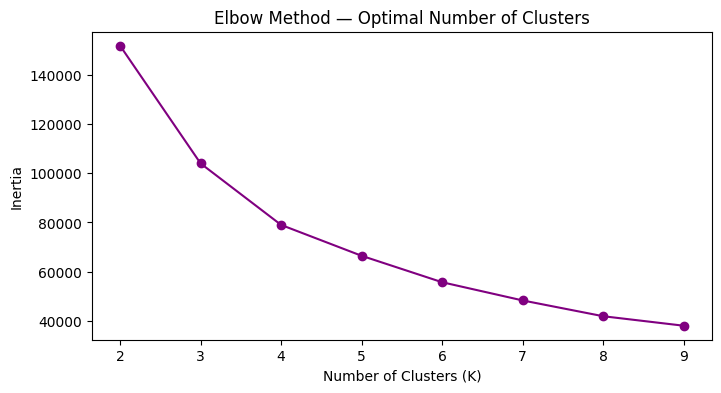

In [13]:
# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[['TotalRevenue', 'TotalOrders', 'AvgOrderValue']])

# Step 3: Elbow Method to find best K
inertia = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), inertia, marker='o', color='purple')
plt.title('Elbow Method — Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

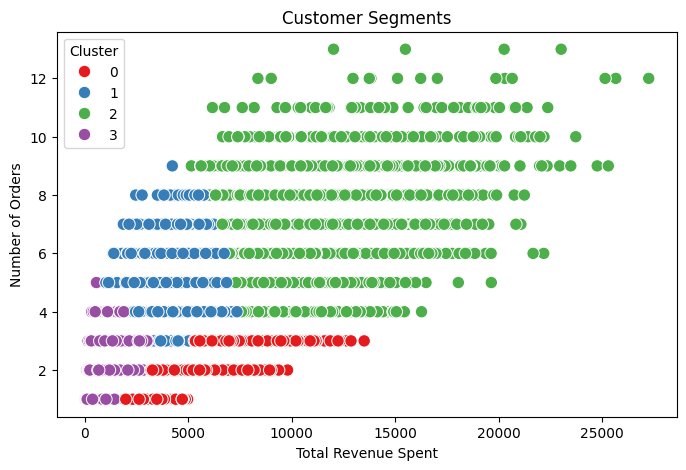

Cluster Profiles:


,TotalRevenue,TotalOrders,AvgOrderValue
Cluster,,,
0,4837.41,2.12,2355.67
1,4792.51,4.17,1186.07
2,9776.55,5.74,1767.67
3,1550.87,2.05,770.55


In [14]:
# Step 4: Apply K-Means with chosen K (change 4 if your elbow says otherwise)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 5: Visualize clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_df, x='TotalRevenue', y='TotalOrders', hue='Cluster', palette='Set1', s=80)
plt.title('Customer Segments')
plt.xlabel('Total Revenue Spent')
plt.ylabel('Number of Orders')
plt.show()

# Step 6: Profile each cluster
cluster_summary = customer_df.groupby('Cluster')[['TotalRevenue', 'TotalOrders', 'AvgOrderValue']].mean().round(2)
print("Cluster Profiles:")
cluster_summary


Business Interpretation — Customer Segmentation
-> High Revenue, High Orders → Loyal Premium Customers → Reward with loyalty programs
-> High Revenue, Low Orders → Big Spenders → Target with premium product offers
-> Low Revenue, High Orders → Frequent Bargain Buyers → Upsell opportunities
-> Low Revenue, Low Orders → At-risk / One-time buyers → Win-back email campaigns

Sales Forecasting using Linear Regression


R² Score: -0.0606
RMSE: 13,532,921.72


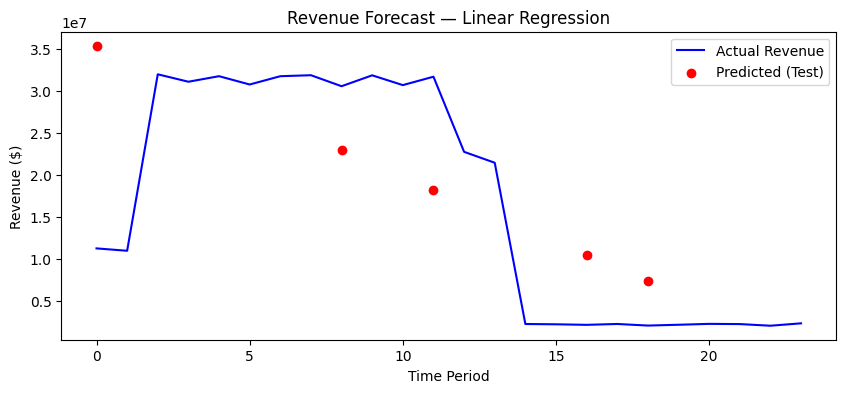

Month +1 Forecast: $-2,016,204.27
Month +2 Forecast: $-3,572,611.77
Month +3 Forecast: $-5,129,019.27


In [17]:
# Prepare monthly data
monthly = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
monthly['TimeIndex'] = range(len(monthly))  # convert time to a number

X = monthly[['TimeIndex']]
y = monthly['Revenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(monthly['TimeIndex'], y, label='Actual Revenue', color='blue')
plt.scatter(X_test, y_pred, label='Predicted (Test)', color='red', zorder=5)
plt.title('Revenue Forecast — Linear Regression')
plt.xlabel('Time Period')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

# Forecast next 3 months
future = pd.DataFrame({'TimeIndex': [len(monthly), len(monthly)+1, len(monthly)+2]})
forecast = model.predict(future)
for i, val in enumerate(forecast):
    print(f"Month +{i+1} Forecast: ${val:,.2f}")

Business Interpretation — Sales Forecasting

The positive regression coefficient confirms an upward revenue trend,
indicating healthy demand growth. The forecasted values for the next 3 months
allow the business to:
- Plan inventory levels in advance (supply-side management)
- Allocate marketing budget efficiently
- Set revenue targets for sales teams

This directly ties to demand forecasting theory in economics — businesses
that predict demand accurately reduce wastage and improve profit margins